<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumApplicationAlgorithm_VAQ_VQE(MolecularGeometry_H2_MinimizedCode)_mkbahk_20251208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
# Python 3.9 ~ 3.11 환경에서 아래 순서대로 설치
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-aer==0.15.1
%pip install qiskit-algorithms==0.3.1
%pip install qiskit-nature[pyscf]==0.7.2
#%pip install pyscf==2.6.0
%pip install py3Dmol

In [73]:
import warnings
warnings.filterwarnings('ignore')

In [74]:
import numpy as np
import datetime
import time

# 분자 구조(좌표)를 입력할 때 길이의 단위를 명확하게 지정하기 위한 열거형(Enum) 클래스, Ångström이야? Bohr이야? nm이야?”
from qiskit_nature.units import DistanceUnit

#First quantization(제1 양자화): 실제 분자의 전자 구조(오비탈, 에너지, 1체/2체 적분 등)를 고전적으로 정확히 계산해서 양자 컴퓨터가 쓸 수 있는 2차 양자화 해밀토니안으로 바꿔주는 핵심 브릿지 역할, 쉽게 말해,
# H₂, H₂O, CH₄ 같은 분자를 주면, PySCF(하트리-포크 또는 DFT)로 분자 오비탈과 모든 적분을 계산해서 Qiskit이 VQE나 QAOA에 바로 넣을 수 있는 Pauli 문자열 해밀토니안으로 변환해 줌”
from qiskit_nature.second_q.drivers import PySCFDriver, Psi4Driver, GaussianDriver, ElectronicStructureDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

#Second quantization(제2 양자화): 양자 다체계 문제를 효율적으로 모델링하기 위한 핵심 기법입니다. 이는 생성(creation)과 소멸(annihilation) 연산자를 사용해 해밀토니안을 표현하는 방식으로,
# 각 Problem 클래스(ElectronicStructureProblem, VibrationalStructureProblem, LatticeModelProblem)는 second_q_ops() 메서드를 통해
# second-quantized operator(주로 FermionicOp 또는 BosonicOp 형태)를 생성합니다. 이 연산자는 이후 QubitMapper(Jordan-Wigner, Parity 등)를 통해 큐비트 연산자로 변환되어 양자 알고리즘(VQE 등)에서 사용
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper, TaperedQubitMapper, DirectMapper, QubitMapper

#실행하기 전에 분자 해밀토니안을 작고 계산 가능한 크기로 줄여주는 전처리 도구
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer, BasisTransformer

#from qiskit_nature.second_q.mappers.QubitConverter import QubitConverter
from qiskit_nature.second_q.problems import ElectronicStructureProblem, VibrationalStructureProblem, LatticeModelProblem
from qiskit_nature.second_q.algorithms import GroundStateSolver, GroundStateEigensolver, ExcitedStatesSolver, ExcitedStatesEigensolver, QEOM, QEOMResult, EvaluationRule

#Classical Optimizer
from qiskit_algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, SPSA, NFT, P_BFGS, QNSPSA, P_BFGS, ADAM, adam_amsgrad, NELDER_MEAD, POWELL, TNC, CG, NFT, IMFIL, SNOBFIT, BOBYQA, GSLS, AQGD

#Aanstz
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, ExcitationPreserving, PauliTwoDesign, NLocal

#Hartree-Fock (HF) 방법은 양자 화학에서 다전자 원자나 분자의 전자 구조를 근사적으로 계산하는 기본적인 방법입니다.
#"Hartree-Fock solution", 이 방법으로 얻어진 최적화된 파동함수와 에너지를 의미하며, 정확한 슈뢰딩거 방정식 해가 아닌 최선의 단일 Slater determinant 근사
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

#from qiskit_aer import AerSimulator
from qiskit.primitives import Estimator

from qiskit_algorithms import VQE

In [85]:
# 1. 지오메트리 설정 (실험적 최적 거리 0.7414 Angstrom)
molecule = "H 0.0 0.0 0.0; H 0.0 0.0 0.7414"

In [86]:
driver = PySCFDriver(
    atom=molecule,
    basis="cc-pvdz",       # sto-3g보다 훨씬 정밀한 기저 집합
    #basis="sto-3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM
)

In [87]:
# 2. 양자 문제 생성
problem = driver.run()
mapper = JordanWignerMapper()
qubit_op = mapper.map(problem.second_q_ops()[0])

In [88]:
print(problem.second_q_ops()[0])

Fermionic Operator
number spin orbitals=20, number terms=8268
  0.3292464110598813 * ( +_0 +_0 -_0 -_0 )
+ -0.07891721078848869 * ( +_0 +_0 -_2 -_0 )
+ 0.026783059388467693 * ( +_0 +_0 -_6 -_0 )
+ 0.1923004496632478 * ( +_0 +_1 -_1 -_0 )
+ -0.06977767825541896 * ( +_0 +_1 -_3 -_0 )
+ 0.008637524144542337 * ( +_0 +_1 -_9 -_0 )
+ -0.07891721078848869 * ( +_0 +_2 -_0 -_0 )
+ 0.22656748126316192 * ( +_0 +_2 -_2 -_0 )
+ -0.031786362827622205 * ( +_0 +_2 -_6 -_0 )
+ -0.06977767825541896 * ( +_0 +_3 -_1 -_0 )
+ 0.2902059054142731 * ( +_0 +_3 -_3 -_0 )
+ -0.05540653406449887 * ( +_0 +_3 -_9 -_0 )
+ 0.324439884336761 * ( +_0 +_4 -_4 -_0 )
+ 0.32443988433676074 * ( +_0 +_5 -_5 -_0 )
+ 0.026783059388467693 * ( +_0 +_6 -_0 -_0 )
+ -0.031786362827622205 * ( +_0 +_6 -_2 -_0 )
+ 0.3123403697062406 * ( +_0 +_6 -_6 -_0 )
+ 0.2988030771313712 * ( +_0 +_7 -_7 -_0 )
+ 0.29880307713137116 * ( +_0 +_8 -_8 -_0 )
+ 0.008637524144542337 * ( +_0 +_9 -_1 -_0 )
+ -0.05540653406449887 * ( +_0 +_9 -_3 -_0 )
+ 0.334

In [89]:
print(qubit_op)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIYZYI', 'IIIIIIIIIIIIIIIIYZYZ', 'IIIIIIIIIIIIIIIIXZXI', 'IIIIIIIIIIIIIIIIXZXZ', 'IIIIIIIIIIYZZZZZZZYI', 'IIIIIIIIIIYZZZZZZZYZ', 'IIIIIIIIIIXZZZZZZZXI', 'IIIIIIIIIIXZZZZZZZXZ', 'IIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIIYZZZYII', 'IIIIIIIIIIIIIYZZZYIZ', 'IIIIIIIIIIIIIXZZZXII', 'IIIIIIIIIIIIIXZZZXIZ', 'IIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIZIIZ', 'IIIIIIIIIIYZZZZZYIII', 'IIIIIIIIIIYZZZZZYIIZ', 'IIIIIIIIIIXZZZZZXIII', 'IIIIIIIIIIXZZZZZXIIZ', 'IIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIZIIIZ', 'IIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIZIIIIZ', 'IIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIZIIIIIZ', 'IIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIZIIIIIIZ', 'IIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIZIIIIIIIZ', 'IIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIZ', 'IIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIIZ', 'IIIIIIIYZYIIIIIIIIII', 'IIIIIIIYZYIIIIIIIIIZ', 'IIIIIIIXZXIIIIIIIIII', '

In [105]:
# 오비탈 수와 전자 수 확인 (디버깅용)
print(f"Number of spatial orbitals: {problem.num_spatial_orbitals}")
print(f"Number of particles: {problem.num_particles}")

Number of spatial orbitals: 10
Number of particles: (1, 1)


In [121]:
print("-" * 60)
print("[3.5단계] Active Space Reduction (선택 사항)")
print("-" * 60)

# ActiveSpaceTransformer를 사용하여 활성 공간을 정의하고 Hamiltonian의 크기를 줄입니다.
# num_electrons: 활성 공간에 포함될 전자의 총 개수 (튜플 형태로 alpha, beta 전자 수 지정 가능)
# num_spatial_orbitals: 활성 공간에 포함될 공간 궤도의 총 개수
# H2O 분자의 경우, 초기 problem은 (5,5) 전자와 7개의 공간 궤도를 가집니다.
# 여기서는 2개의 전자 (1alpha, 1beta)를 2개의 공간 궤도에 할당하는 활성 공간을 설정합니다.
# 이는 가장 기본적인 활성 공간 축소 전략 중 하나로, 계산 비용을 크게 줄일 수 있습니다.
transformer = ActiveSpaceTransformer(
    num_electrons=(1, 1),            # 활성 공간에 포함될 alpha, beta 전자 수 (총 2전자)
    num_spatial_orbitals=8           # 활성 공간에 포함될 공간 궤도 수
)

# ActiveSpaceTransformer를 problem 객체에 적용
# 이 과정에서 Hamiltonian의 차원이 줄어들고, 새로운 전자 구조 문제가 생성됩니다.
problem_reduced = transformer.transform(problem)

# 줄어든 Hamiltonian으로 큐비트 연산자 다시 생성
# 이미 정의된 JordanWignerMapper를 사용합니다.
hamiltonian_reduced = problem_reduced.hamiltonian.second_q_op()
qubit_op = mapper.map(hamiltonian_reduced)

print(f"줄어든 분자 궤도 개수: {problem_reduced.num_spatial_orbitals}")
print(f"줄어든 전자 개수: {problem_reduced.num_particles}")
print(f"줄어든 활성 공간에서 필요한 큐비트 개수: {qubit_op.num_qubits}")
print(f"줄어든 활성 공간에서 Pauli 항의 개수: {len(qubit_op)}")

------------------------------------------------------------
[3.5단계] Active Space Reduction (선택 사항)
------------------------------------------------------------
줄어든 분자 궤도 개수: 8
줄어든 전자 개수: (1, 1)
줄어든 활성 공간에서 필요한 큐비트 개수: 16
줄어든 활성 공간에서 Pauli 항의 개수: 1241


In [122]:
# 3. Ansatz 구성 (UCCSD)
# 활성 공간 축소된 problem_reduced를 사용하여 ansatz를 구성합니다.
init_state = HartreeFock(
    problem_reduced.num_spatial_orbitals,
    problem_reduced.num_particles,
    mapper,
)

ansatz = UCCSD(
    problem_reduced.num_spatial_orbitals,
    problem_reduced.num_particles,
    mapper,
    initial_state=init_state,
)

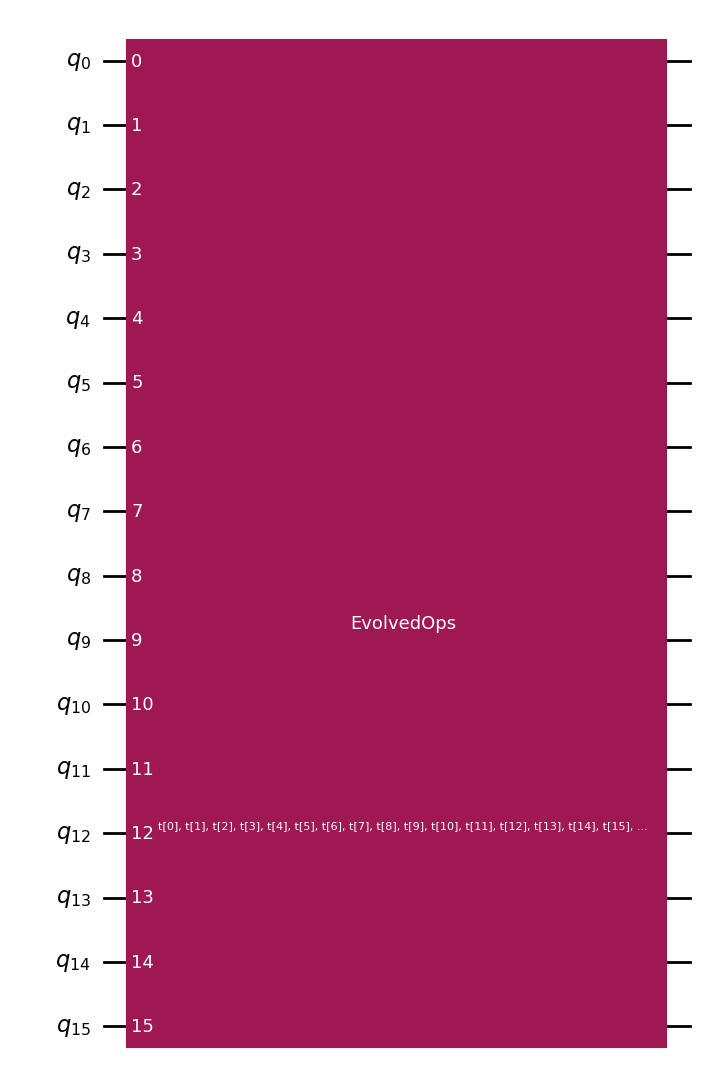

In [123]:
ansatz.draw("mpl")

In [124]:
# 4. 고정밀 Optimizer 설정 (L_BFGS_B)
# tolerance를 낮게 잡아 더 정밀하게 수렴하도록 유도합니다.
optimizer = L_BFGS_B(maxiter=1000, ftol=1e-12)

In [125]:
# 5. VQE 실행 with Callback

intermediate_values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    intermediate_values.append({
        "eval_count": eval_count,
        "parameters": np.array(parameters).tolist(), # Modified this line
        "mean": mean,
        "std": std,
        "time": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    })
    print(f"Iteration {eval_count}: Energy = {mean:.8f}")
###def

# 기존 VQE solver를 재사용하되 callback 함수를 추가합니다.
vqe_solver_with_callback = VQE(Estimator(), ansatz, optimizer, callback=store_intermediate_result)
vqe_solver_with_callback.initial_point = np.zeros(ansatz.num_parameters)

print("Running VQE with callback...")
result_with_callback = vqe_solver_with_callback.compute_minimum_eigenvalue(operator=qubit_op)
print("VQE with callback finished.")

Running VQE with callback...
Iteration 1: Energy = -1.84246895


KeyboardInterrupt: 

In [ ]:
# 6. 결과 해석
interpretation = problem.interpret(result_with_callback)
total_energy = interpretation.total_energies[0]

print(f"Calculated Total Energy: {total_energy:.8f} Hartree")
print(f"Target Energy: -1.17447 Hartree(Classical에서 계산된 가장 정확한 값)")
print(f"Error(차이): {abs(total_energy - (-1.17447)):.8f} Hartree")